In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v)) # creating edge between child and node
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr = {'rankdir':'LR'}) # left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in graph, create a rectangular node for it
        dot.node(name = uid , label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            # if this value is a result of some operation, create an op node that is a oval one
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

In [4]:
class Value:
    def __init__(self, data, _children=(), _op = ' ', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda:None #empty function like a leaf node
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"

    def __neg__(self):
        return self * -1
        
    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        output = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * output.grad
            other.grad += 1.0 * output.grad
        output._backward = _backward
        return output
        
    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        output = Value(self.data - other.data, (self, other), '-')
        
        def _backward():
            self.grad += 1.0 * output.grad
            other.grad -= 1.0 * output.grad

        output._backward = _backward
        return output
 
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        output = Value(self.data * other.data, (self, other),'*')
        def _backward():
            self.grad += other.data * output.grad
            other.grad += self.data * output.grad
        output._backward = _backward
        return output

    def exp(self):
        x = self.data
        output = Value(math.exp(x),(self,), 'exp')
        def _backward():
            self.grad += output.data * output.grad
        output._backward = _backward        
        return output

    def __pow__(self,other):
        assert isinstance(other,(int,float)), "only supporting int/float powers for now"
        output = Value(self.data ** other, (self,), f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * output.grad
        output._backward = _backward
        return output
        
    def __rmul__(self,other):
        return self * other

    def __truediv__(self,other):
        return self * other ** -1
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x)+1)
        output = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * output.grad
        output._backward = _backward
        return output
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [5]:
import torch

print(torch.__version__)
print(torch.cuda.is_available())

2.3.0+cpu
False


In [6]:
x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True

x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True

w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double()
b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data) # tensor
print(o.data.item()) # value stripped out from the tensor
o.backward()

print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

tensor([0.7071], dtype=torch.float64)
0.7071066904050358
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [7]:
torch.Tensor([[1,2,3],[4,5,6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [8]:
#forwarding a single neuron
import random
from math import tanh

class Neuron:
    def __init__(self, ninputs):#self is inputs
        self.w = [Value(random.uniform(-1,1)) for _ in range(ninputs)] #take input that is between -1 and 1 wrt each input
        self.b = Value(random.uniform(-1,1)) #controls the triggered happiness
    def __call__(self,x):
        #w*x + b
        #Step1: pairwise multiplication of every element of w with x
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # by default the 2nd parameter of sum is 0.0 here we used bias
        out = act.tanh()
        return out

In [9]:
# a layer of neurons = set of neurons evaluated independently
class Layer:
    def __init__(self,ninputs,noutputs):
        self.neurons = [Neuron(ninputs) for _ in range(noutputs)]
    def __call__(self,x):
        outputs = [neuron(x) for neuron in self.neurons]
        return outputs[0] if len(outputs) == 1 else outputs
    

In [10]:
# x = [2.0,3.0] # self
# n = Neuron(2) #ninputs
# n(x) # triggers __call__ fn


In [11]:
#multilayer perceptron with each layer feeding other layer = MLP
class MLP:
    def __init__(self, ninputs,noutputs): #noutputs: list of sizes of each layer
        sz = [ninputs] + noutputs
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(noutputs))]
        
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x     

In [12]:
x = [2.0,3.0,-1.0] # self
n = MLP(3,[4,4,1]) #ninputs
n(x) # triggers __call__ fn


Value(data=-0.7650164939937458)

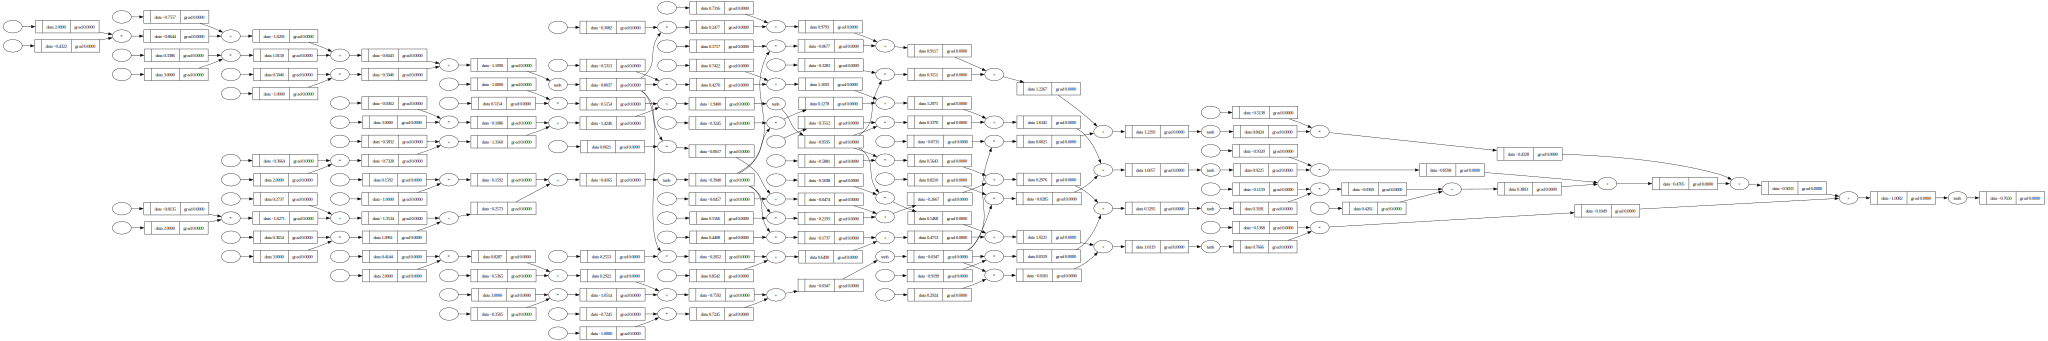

In [13]:
draw_dot(n(x)) #expression got relatively involved leading to a single output

In [14]:
#creating a tiny dataset
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
] # 4 possible inputs
ys = [1.0,-1.0,-1.0,1.0] #desired targets 1.0 for  [2.0,3.0,-1.0]

In [15]:
y_prediction = [n(x) for x in xs]
y_prediction # these values are very different from what we want to achieve - targets

[Value(data=-0.7650164939937458),
 Value(data=-0.731895924175395),
 Value(data=-0.2074763828398647),
 Value(data=-0.7653415409905526)]

In [16]:
#tuning weights for better prediction of desired targets
loss =[ (y_output - y_groundtruth)**2 for y_groundtruth, y_output in zip(ys,y_prediction)]
loss # more we are far away from the target more will be the loss

[Value(data=3.115283224069975),
 Value(data=0.07187979547376558),
 Value(data=0.6280936837565847),
 Value(data=3.116430756346899)]

In [20]:
loss = sum(((y_output - Value(y_groundtruth))**2 for y_groundtruth, y_output in zip(ys, y_prediction)), Value(0.0))
print("Total loss:", loss.data)


Total loss: 6.931687459647224


In [21]:
# we need to tune the loss to be 0
loss.backward()

In [19]:
n.layers[0].neurons[0].w[0].grad

0.0

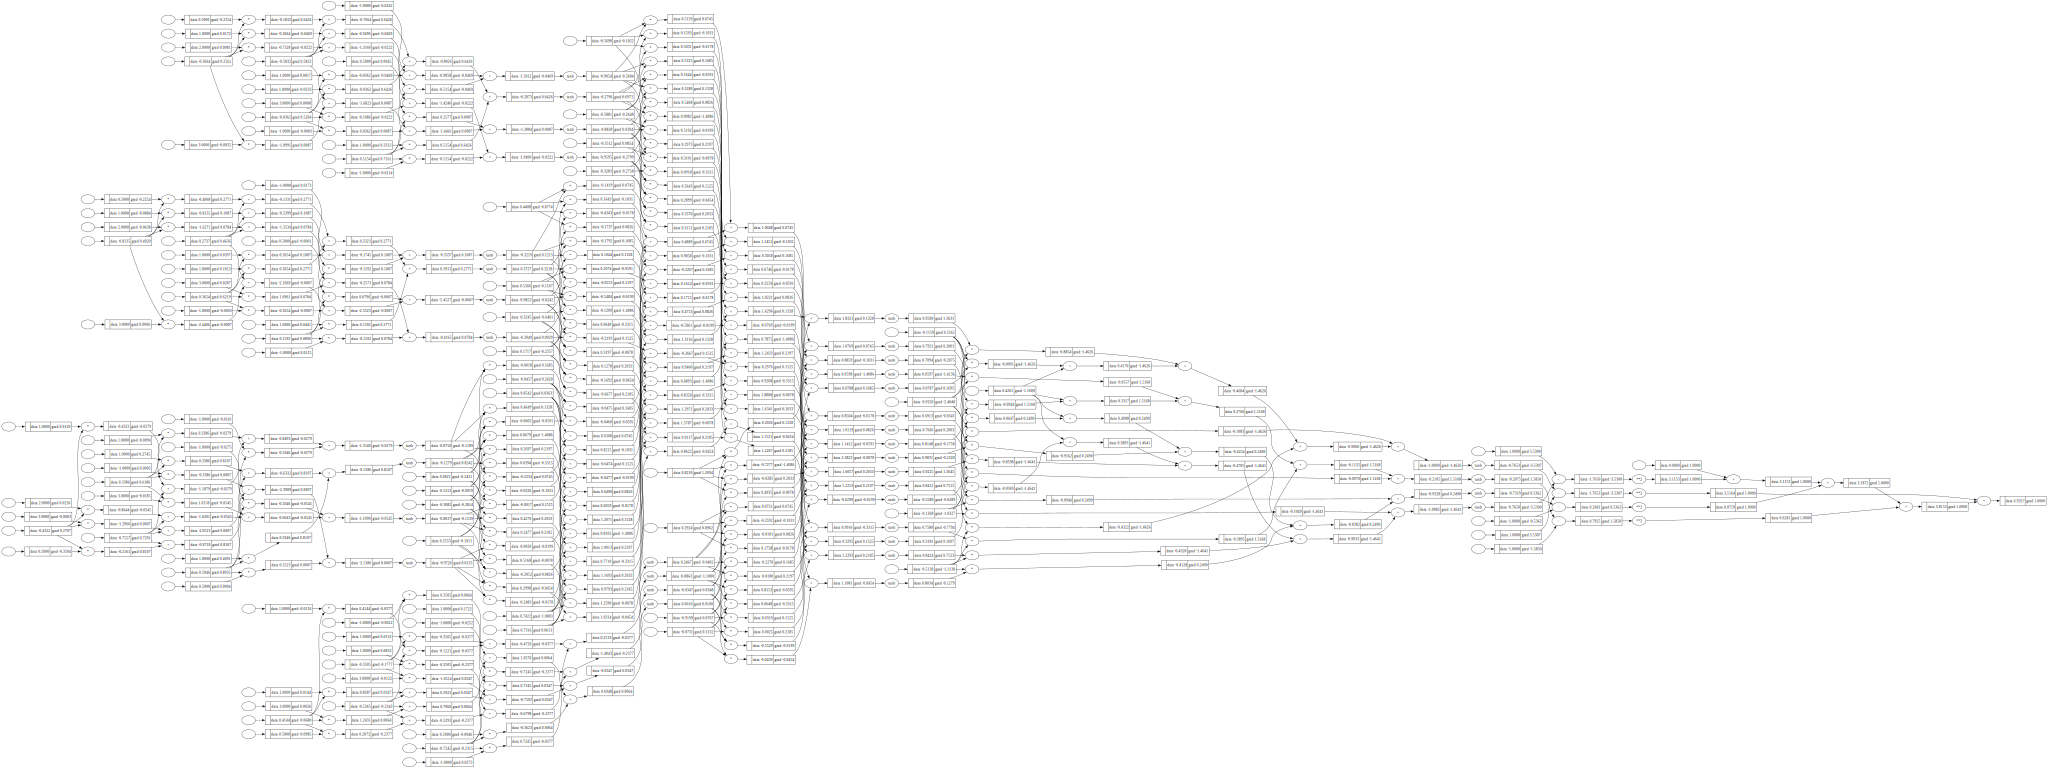

In [22]:
draw_dot(loss)